In [1]:
# Unpacking best-performing text classiffier
# January 2025
# Violeta Berdejo-Espinola

In [2]:
%pip install mpu scikit-learn matplotlib numpy embetter imblearn scipy shap sentence_transformers 


[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# read data

In [3]:
import mpu

# raw corpus

x = mpu.io.read('../data/v2/corpus_raw.pickle')

# y

y = mpu.io.read('../data/v2/y.pickle')

# calculate weights

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y)
weights = compute_class_weight('balanced', classes=classes, y=y)
class_weight_dict = dict(zip(classes, weights))

# best models


In [4]:
from imblearn.pipeline import make_pipeline 

from embetter.text import SentenceEncoder

from sklearn.svm import SVC

from sklearn.model_selection import cross_val_predict, StratifiedKFold

from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix

import numpy as np

def train_eval_best_model(x_train, y_train, x_test, y_test, kfold, C):
    
    """"
    Train and test model
    
    Parameters:
    -----------
    x_train, x_test: list of strings
        raw text to create embeddings
    y_train_y_test: array 
        binary labels
    text_length: string 
        indicating whther it is 'text and asbtract' or 'text, asbtract, and main text'
    kfold: int
        indicating number of folds for cross validation
    embedding_model: string
        instantiation of embedding model
    random_state: int
        seed
    C: int
        strength of regularisation parametre

        
    Returns:
    --------
    Dictionary with scores.
    Aray of predictions and predicted probabilities.
    Log losss values for test and train set.
    Array of test set predicitons
    Model object
    AIC value
    """
    
    pipeline = make_pipeline(
        SentenceEncoder('paraphrase-multilingual-mpnet-base-v2'),
        # LogisticRegression(solver='liblinear', class_weight={0: weight_for_class_0, 1: weight_for_class_1}, random_state=42, C=C)
        SVC(kernel='linear', class_weight=class_weight_dict, probability=True, C=C)

    )
    
    #train model
    y_train_pred_cv = cross_val_predict(pipeline, x_train, y_train, cv=StratifiedKFold(kfold), method='predict') 

    pipeline.fit(x_train, y_train)
    
    # make predictions
    y_train_pred = pipeline.predict(x_train)

    y_test_pred = pipeline.predict(x_test)
    
    y_train_pred_proba = pipeline.predict_proba(x_train) 
    
    y_test_pred_proba = pipeline.predict_proba(x_test)  
    
    # log loss 
    logloss_tr = log_loss(y_train, y_train_pred_proba) 
    
    logloss_ts = log_loss(y_test, y_test_pred_proba)
    
    # model object -svm / logreg-
    model = pipeline.steps[-1][1]  
    
    # compute AIC
    probs = np.clip(y_train_pred_proba, 1e-15, 1 - 1e-15)

    # compute log-likelihood
    log_likelihood = np.sum(np.array(y_train) * np.log(probs[:, 1]) + (1 - np.array(y_train)) * np.log(probs[:, 0]))

    # estimate number of parameters
    k = model.support_vectors_.shape[1] + 1  # Approximate for svm: num features + bias  
    # k = model.coef_.size + model.intercept_.size  # Total number of parameters for logreg ---> uncomment this for LOGISTIC REGRESSION 

    aic = 2 * k - 2 * log_likelihood

    
    # get model scores 
    scores = {
        'CV': kfold,
        'F1_tr_cv': round(f1_score(y_train, y_train_pred_cv), 3),
        'F1_tr': round(f1_score(y_train, y_train_pred), 3),
        'F1_ts': round(f1_score(y_test, y_test_pred), 3),
        'Precision_tr_cv': round(precision_score(y_train, y_train_pred_cv), 3),
        'Precision_tr': round(precision_score(y_train, y_train_pred), 3),
        'Precision_ts': round(precision_score(y_test, y_test_pred), 3),
        'Recall_tr_cv': round(recall_score(y_train, y_train_pred_cv), 3),
        'Recall_tr': round(recall_score(y_train, y_train_pred), 3),
        'Recall_ts': round(recall_score(y_test, y_test_pred), 3)
        }
    
    print(f"AIC: {aic}")
    print(f'loss training set: {logloss_tr}, \nloss test set {logloss_ts}')
    print(f'confusion matrix train set:\n{confusion_matrix(y_train, pipeline.predict(x_train))}')
    print(f'confusion matrix test set:\n{confusion_matrix(y_test, pipeline.predict(x_test))}') 
 
    return scores, y_train_pred, y_test_pred, y_train_pred_proba, y_test_pred_proba, logloss_tr, logloss_ts, model, aic

/Users/uqvberde/Projects/classifier_spanish/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# train-test model on different train-test partitions


run on a few different train-test partitions, then report the average with the standard error.
I should see greater performance with more data, but also lower variance across the different random samples

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42, stratify=y)

scores1, y_train_pred1, y_test_pred1, y_train_pred_proba1, y_test_pred_proba1, logloss_tr1, logloss_ts1, model1, aic1 = train_eval_best_model(x_train, y_train, x_test, y_test, 2, 0.01)

print(scores1)
print(np.mean(y_test_pred1 == y_test))

AIC: 1790.9941581193264
loss training set: 0.028490333121545742, 
loss test set 0.03696971634632434
confusion matrix train set:
[[3538  867]
 [   0   35]]
confusion matrix test set:
[[867 234]
 [  0   9]]
{'CV': 2, 'F1_tr_cv': 0.068, 'F1_tr': 0.075, 'F1_ts': 0.071, 'Precision_tr_cv': 0.035, 'Precision_tr': 0.039, 'Precision_ts': 0.037, 'Recall_tr_cv': 0.829, 'Recall_tr': 1.0, 'Recall_ts': 1.0}
0.7891891891891892


In [6]:
y_test_pred_proba1

array([[9.74640405e-01, 2.53595949e-02],
       [9.82640672e-01, 1.73593280e-02],
       [9.99772176e-01, 2.27824100e-04],
       ...,
       [9.97964672e-01, 2.03532840e-03],
       [9.91941325e-01, 8.05867469e-03],
       [9.93571335e-01, 6.42866549e-03]])

In [7]:
from scipy import stats

# stats.sem([logloss_ts1, logloss_ts2, logloss_ts3, logloss_ts])

# explainability

In [8]:
import shap
from sentence_transformers import SentenceTransformer

classes = np.unique(y)

# encode text

encoder = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')
X = encoder.encode(x)
print(f"Encoded data shape: {X.shape}")

# define SHAP Masker and Prediction Function (for text-based explanation) ---

masker = shap.maskers.Text(tokenizer=r"\W+") # split on non-word characters

def prediction_function(text_batch):
    
    """Encodes perturbed text into embeddings and returns class probabilities."""
    
    # Ensure text_batch is a list of strings, SHAP might pass numpy arrays
    if isinstance(text_batch, np.ndarray):
        text_batch = text_batch.tolist()
    try:
        embeddings = encoder.encode(text_batch) 
        probas = model1.predict_proba(embeddings)

        return probas#[:, 0]  # shape: (batch_size,)
   
    except Exception as e:
        print(f"Error during prediction function execution: {e}")
        # Return a default value or re-raise depending on desired handling
        # Returning zeros matching expected output shape might help SHAP proceed
        return np.zeros((len(text_batch), len(classes))) # Return shape (batch_size, num_classes)
    
# initialize SHAP Explainer ---

# Make sure prediction_function returns probabilities for all classes
explainer = shap.Explainer(prediction_function, masker)#, output_names=["Class 0", "Class 1"]) # Optional: name outputs
print("SHAP Explainer initialized.")

Encoded data shape: (5550, 768)
SHAP Explainer initialized.


In [9]:
print(f"\nExplaining a positive instance.")

shap_values_t = explainer(x_test[385:386]) #

print("SHAP values calculated.")


Explaining a positive instance.


SHAP values calculated.


In [10]:
shap.plots.text(shap_values_t)

In [11]:
y_test_pred_proba1[385]

array([0.98579201, 0.01420799])

In [12]:
print(f"\nExplaining a negative instance")

shap_values_neg = explainer(x_test[0:1]) #

print("SHAP values calculated.")


Explaining a negative instance


SHAP values calculated.


In [13]:
shap.plots.text(shap_values_neg)

In [14]:
y_test_pred_proba1[0]

array([0.97464041, 0.02535959])

# plots


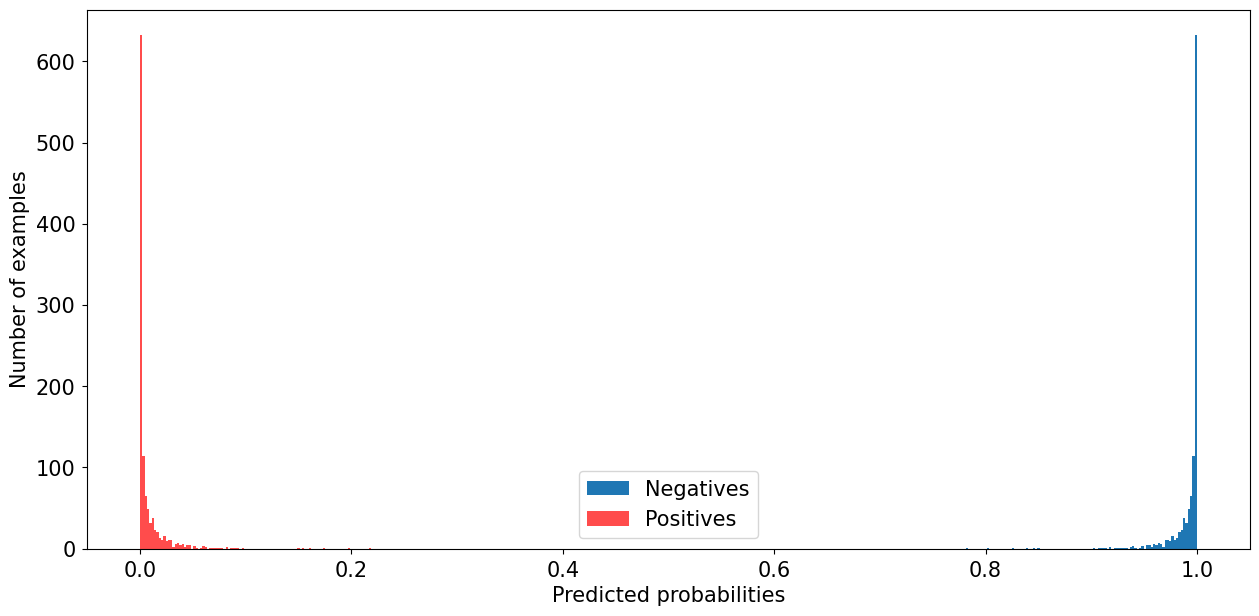

In [15]:
import matplotlib.pyplot as plt

y_pred_ts_p = y_test_pred_proba1[:,1] # subset class of interest --> 1d array
y_pred_ts_n = y_test_pred_proba1[:,0]

plt.figure(figsize=(15,7))
plt.hist(y_pred_ts_n, bins=100, label='Negatives')
plt.hist(y_pred_ts_p, bins=100, label='Positives', alpha=0.7, color='r')
plt.xlabel('Predicted probabilities', fontsize=15)
plt.ylabel('Number of examples', fontsize=15)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=15, pad=5)
# plt.savefig('../results/model_scores/predicted_proba_logreg_ts.png', dpi=800)
plt.show() 


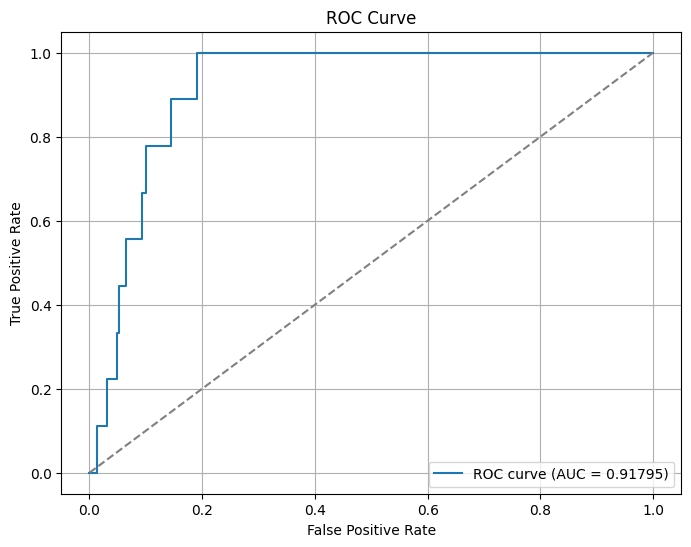

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# True labels and predicted probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_pred_ts_p)
auc_score = roc_auc_score(y_test, y_pred_ts_p)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.5f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
# plt.savefig('../results/v2/roc_curve.png', dpi=1000)
plt.show()

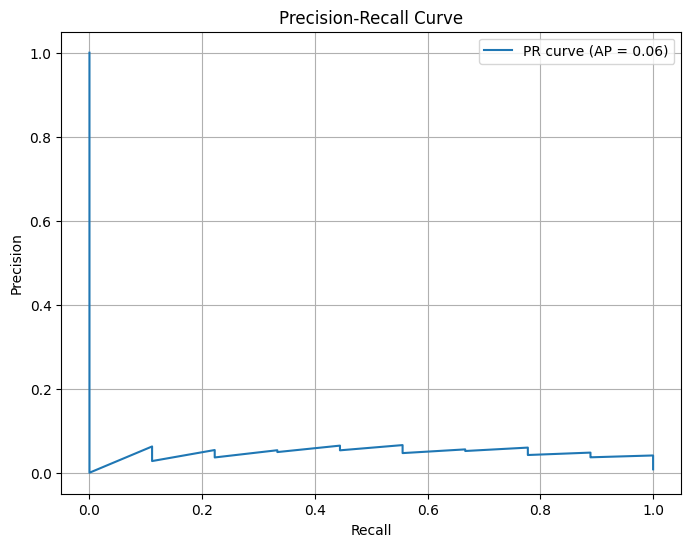

In [17]:
from sklearn.metrics import precision_recall_curve, average_precision_score

y_true = y_test

precision, recall, thresholds = precision_recall_curve(y_true, y_pred_ts_p)
ap_score = average_precision_score(y_true, y_pred_ts_p)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f'PR curve (AP = {ap_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()